In [30]:
! pip install scikit-learn

  Using cached joblib-1.3.2-py3-none-any.whl.metadata (5.4 kB)
   ---------------------------------------- 0.0/9.2 MB ? eta -:--:--
   -- ------------------------------------- 0.6/9.2 MB 11.8 MB/s eta 0:00:01
   --------------------------- ------------ 6.3/9.2 MB 68.0 MB/s eta 0:00:01
   ---------------------------------------- 9.2/9.2 MB 73.6 MB/s eta 0:00:00
Using cached joblib-1.3.2-py3-none-any.whl (302 kB)


In [ ]:
! pip install gym

In [ ]:
! pip install seaborn


  Using cached seaborn-0.13.0-py3-none-any.whl.metadata (5.3 kB)
Using cached seaborn-0.13.0-py3-none-any.whl (294 kB)


In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np

In [2]:
import torch
import torch.nn as nn
import random
import gym
import numpy as np
import cv2

# Preprocess each frame from 210x160 to 84x84
class Preprocess(gym.ObservationWrapper):
    
    def __init__(self, env=None):
        super(Preprocess, self).__init__(env)
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=(84, 84, 3), dtype=np.uint8)

    def observation(self, obs):
        return Preprocess.process(obs)

    @staticmethod
    def process(frame):
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY) 
        resized_frame = cv2.resize(frame, (84, 84), interpolation=cv2.INTER_AREA)
        result = np.reshape(resized_frame, [84, 84, 1])
        return np.concatenate([result] * 3, axis=2).astype(np.uint8)

# Change axis accordingly to neural network input
class ChangeAxis(gym.ObservationWrapper):
    
    def __init__(self, env):
        super(ChangeAxis, self).__init__(env)
        old_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=(old_shape[-1], old_shape[0], old_shape[1]), dtype=np.uint8)

    def observation(self, observation):
        return np.moveaxis(observation, 2, 0)

In [20]:
#Convolutional neural network
class DQN_Network(nn.Module):
    
    def __init__(self, input_shape, n_actions):
        super(DQN_Network, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        output_size = self.get_output_size(input_shape)
        self.fc = nn.Sequential(
            nn.Linear(output_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )
    
    def get_output_size(self, input_shape):
        ot = self.conv(torch.zeros(1, *input_shape))
        return int(np.prod(ot.size()))
    
    def forward(self, x):
        x = x.float() / 255.0
        mid_output = self.conv(x).view(x.size()[0], -1)
        return self.fc(mid_output)


In [21]:

#DQN agent 
class DQN_Agent:

    def __init__(self, state_space, action_space, epsilon_max, epsilon_min, rb_size, batch_size, gamma, lr, dqn):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.state_space = state_space
        self.action_space = action_space        
       
        self.dqn = dqn
        self.dqn_target = dqn
        
        self.optimizer = torch.optim.Adam(self.dqn.parameters(), lr=lr)
        self.l1 = nn.SmoothL1Loss().to(self.device)
        self.batch_size = batch_size
        self.gamma = gamma
        
        self.epsilon = epsilon_max
        self.epsilon_max = epsilon_max
        self.epsilon_min = epsilon_min
        self.epsilon_decay = (epsilon_max - epsilon_min)/20000

        self.mem_size = rb_size
        self.state_buffer = torch.zeros(self.mem_size, *self.state_space, dtype=torch.uint8)
        self.action_buffer = torch.zeros(self.mem_size, 1)
        self.reward_buffer = torch.zeros(self.mem_size, 1)
        self.next_state_buffer = torch.zeros(self.mem_size, *self.state_space, dtype=torch.uint8)
        self.done_buffer = torch.zeros(self.mem_size, 1)
        self.last_pos = 0
        self.current = 0
    
    def select_action(self, state):
        if random.random() < self.epsilon:  
            return torch.tensor([[random.randrange(self.action_space)]])
        else:
            return torch.argmax(self.dqn(state.to(self.device))).unsqueeze(0).unsqueeze(0).cpu()
    
    def train(self):
        if self.batch_size > self.current:
            return
        
        states, actions, rewards, next_states, dones = self.sample()
        states = states.float().to(self.device)
        actions = actions.float().to(self.device)
        rewards = rewards.float().to(self.device)
        next_states = next_states.float().to(self.device)
        dones = dones.float().to(self.device)
        
        self.optimizer.zero_grad()
        current = self.dqn(states).gather(1, actions.long())
        target = rewards + torch.mul((self.gamma * self.dqn_target(next_states).max(1).values.unsqueeze(1)), 1 - dones)
    
        loss = self.l1(current, target)
        loss.backward()
        self.optimizer.step()

        self.epsilon -= self.epsilon_decay
        self.epsilon = max(self.epsilon, self.epsilon_min)
        
    def store(self, state, action, reward, next_state, done):
        self.state_buffer[self.last_pos] = state
        self.action_buffer[self.last_pos] = action
        self.reward_buffer[self.last_pos] = reward
        self.next_state_buffer[self.last_pos] = next_state
        self.done_buffer[self.last_pos] = done
        
        self.last_pos = (self.last_pos + 1) % self.mem_size
        self.current = min(self.current + 1, self.mem_size)
    
    def sample(self):
        indices = random.choices(range(self.current), k=self.batch_size)
        states = self.state_buffer[indices]
        actions = self.action_buffer[indices]
        rewards = self.reward_buffer[indices]
        next_states = self.next_state_buffer[indices]
        dones = self.done_buffer[indices]      
        return states, actions, rewards, next_states, dones
        
    def update_target(self):
         self.dqn_target.load_state_dict(self.dqn.state_dict())
            
    def save_models(self):
        torch.save(self.dqn.state_dict(), "state_dict_model.pt")
        torch.save(self.dqn_target.state_dict(), "state_dict_target_model.pt")

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [22]:

def train_agent(env, agent, episodes):
   
    update_target = 200
    total_steps = 0
    total_rewards = 0  # Variable to store the total rewards across episodes
    cumulative_average = 0  # Variable to store the cumulative average of total rewards

    episode_scores = []
    cum_avg_rewards = []
    rewards_per_episode = []
    rolling_avg_last_10 = []
    
    for episode in range(episodes):
        episode_score = 0
        step = 0
        
        state = env.reset()
        state = torch.tensor(np.array(state[0])).unsqueeze(0)
        
        while True:
            action = agent.select_action(state)
            step += 1
            
            next_state, reward, done, _, _ = env.step(int(action[0]))
            next_state = torch.tensor(np.array(next_state)).unsqueeze(0)
            episode_score += reward  
            agent.store(state, action, reward, next_state, done)
            agent.train()
            if step % update_target == 0:
                agent.update_target()
            
            state = next_state
            
            if done:
                total_steps += step
                total_rewards += episode_score
                episode_scores.append(episode_score)
                rewards_per_episode.append(episode_score)
                cumulative_average = total_rewards / (episode + 1)  # Calculate cumulative average
                cum_avg_rewards.append(cumulative_average)
    
                print(f"Score/Episode {episode_score}, {episode}")
                print(f"Cumulative Average: {cumulative_average}")

                # Calculate rolling average of the last 10 episode rewards
                if len(rewards_per_episode) >= 10:
                    rolling_average = pd.Series(rewards_per_episode[-10:]).mean()
                    rolling_avg_last_10.append(rolling_average)
                    print(f"Rolling Average (last 10 episodes): {rolling_average}")
                break        
        
    agent.save_models()
    env.close()
    return episode_scores, cum_avg_rewards, rolling_avg_last_10, total_steps
 



In [23]:
env = gym.make('MsPacman-v4', render_mode="rgb_array")
env.seed(12)
env.action_space.seed(12)
env = Preprocess(env)
env = ChangeAxis(env) 
state_space = env.observation_space.shape
action_space = env.action_space.n


In [24]:
dqn = DQN_Network(state_space, action_space).to(device)
agent = DQN_Agent(state_space=state_space, action_space=action_space, epsilon_max=1.0, epsilon_min=0.02, rb_size=200000, 
                      batch_size=32, gamma=0.95, lr=0.00025, dqn=dqn)

episode_scores, cum_avg_rewards, rolling_avg_last_10, total_steps = train_agent(env=env, agent=agent, episodes=1000)

c:\Users\duygu\miniconda3\envs\pytorch-gpu\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Score/Episode 170.0, 0
Cumulative Average: 170.0
Score/Episode 180.0, 1
Cumulative Average: 175.0
Score/Episode 200.0, 2
Cumulative Average: 183.33333333333334
Score/Episode 170.0, 3
Cumulative Average: 180.0
Score/Episode 350.0, 4
Cumulative Average: 214.0
Score/Episode 200.0, 5
Cumulative Average: 211.66666666666666
Score/Episode 190.0, 6
Cumulative Average: 208.57142857142858
Score/Episode 480.0, 7
Cumulative Average: 242.5
Score/Episode 150.0, 8
Cumulative Average: 232.22222222222223
Score/Episode 250.0, 9
Cumulative Average: 234.0
Rolling Average (last 10 episodes): 234.0
Score/Episode 320.0, 10
Cumulative Average: 241.8181818181818
Rolling Average (last 10 episodes): 249.0
Score/Episode 420.0, 11
Cumulative Average: 256.6666666666667
Rolling Average (last 10 episodes): 273.0
Score/Episode 300.0, 12
Cumulative Average: 260.0
Rolling Average (last 10 episodes): 283.0
Score/Episode 560.0, 13
Cumulative Average: 281.42857142857144
Rolling Average (last 10 episodes): 322.0
Score/Episo

In [25]:
def plot_cumulative_rewards(cum_avg_rewards):
    # Create a DataFrame for the data
    data = {'Episode': range(1, len(cum_avg_rewards) + 1), 'Cumulative_Average': cum_avg_rewards}
    df = pd.DataFrame(data)

    # Create the seaborn plot
    sns.set()
    sns.lineplot(x='Episode', y='Cumulative_Average', data=df)
    plt.title('Episodes vs. Cumulative Average')
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Average')
    plt.show()

In [26]:
def plot_scores(episode_scores):
    # Create a DataFrame for the data
    data = {'Episode': range(1, len(episode_scores) + 1), 'Score': episode_scores}
    df = pd.DataFrame(data)

    # Create the seaborn plot
    sns.lineplot(x='Episode', y='Score', data=df)
    plt.title('Score per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Score')


    reg = LinearRegression().fit(np.arange(len(episode_scores)).reshape(-1, 1), np.array(episode_scores).reshape(-1, 1))
    y_pred = reg.predict(np.arange(len(episode_scores)).reshape(-1, 1))
    plt.plot(y_pred)
    plt.show()

In [27]:
def plot_last_10_avg(avg_array):
    # Plotting the average of the last 10 episode rewards
    plt.plot(avg_array)
    plt.title('Average Reward of the Last 10 Episodes Over Time')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward (Last 10 Episodes)')
    plt.show()

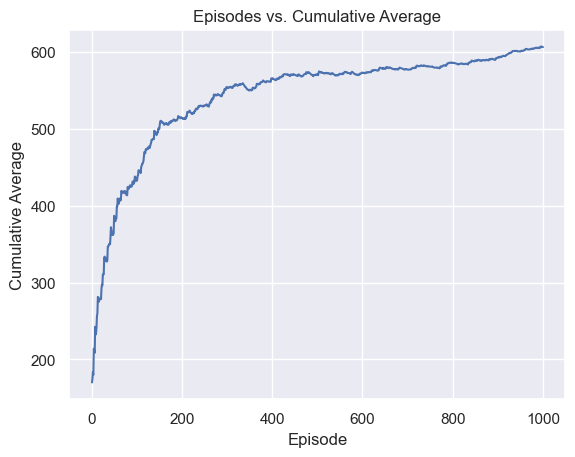

In [34]:
plot_cumulative_rewards(cum_avg_rewards)

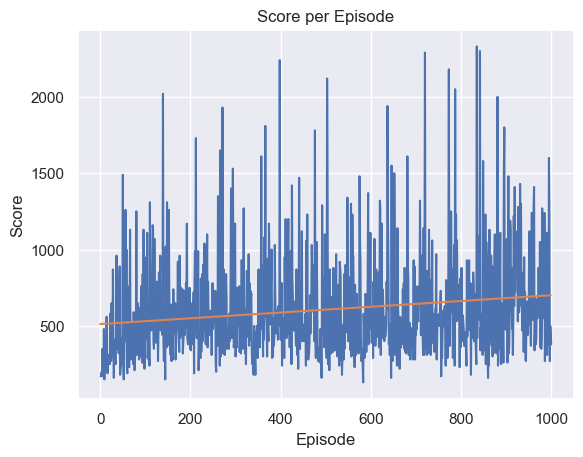

In [35]:
plot_scores(episode_scores)

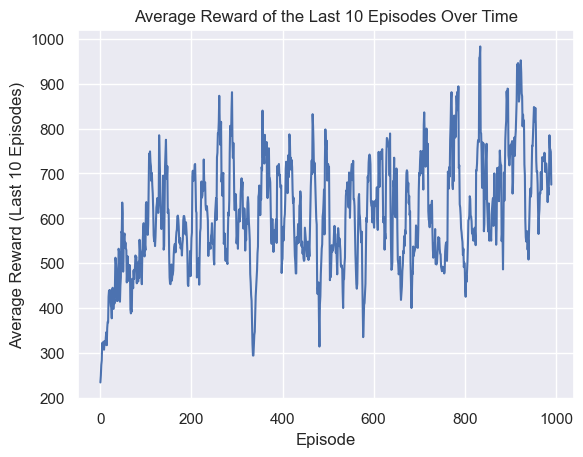

In [30]:
plot_last_10_avg(rolling_avg_last_10)

In [36]:
dqn = DQN_Network(state_space, action_space).to(device)
agent = DQN_Agent(state_space=state_space, action_space=action_space, epsilon_max=1.0, epsilon_min=0.02, rb_size=200000, 
                      batch_size=64, gamma=0.95, lr=0.00025, dqn=dqn)

episode_scores_64, cum_avg_rewards_64, rolling_avg_last_10_64, total_steps_64 = train_agent(env=env, agent=agent, episodes=1000)

Score/Episode 350.0, 0
Cumulative Average: 350.0
Score/Episode 190.0, 1
Cumulative Average: 270.0
Score/Episode 180.0, 2
Cumulative Average: 240.0
Score/Episode 300.0, 3
Cumulative Average: 255.0
Score/Episode 180.0, 4
Cumulative Average: 240.0
Score/Episode 180.0, 5
Cumulative Average: 230.0
Score/Episode 130.0, 6
Cumulative Average: 215.71428571428572
Score/Episode 250.0, 7
Cumulative Average: 220.0
Score/Episode 270.0, 8
Cumulative Average: 225.55555555555554
Score/Episode 210.0, 9
Cumulative Average: 224.0
Rolling Average (last 10 episodes): 224.0
Score/Episode 100.0, 10
Cumulative Average: 212.72727272727272
Rolling Average (last 10 episodes): 199.0
Score/Episode 260.0, 11
Cumulative Average: 216.66666666666666
Rolling Average (last 10 episodes): 206.0
Score/Episode 330.0, 12
Cumulative Average: 225.3846153846154
Rolling Average (last 10 episodes): 221.0
Score/Episode 440.0, 13
Cumulative Average: 240.71428571428572
Rolling Average (last 10 episodes): 235.0
Score/Episode 450.0, 14

# Change network architecture to more complex one

In [31]:
class ComplexDQN_Network(nn.Module):
    
    def __init__(self, input_shape, n_actions):
        super(ComplexDQN_Network, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        output_size = self.get_output_size(input_shape)
        self.fc = nn.Sequential(
            nn.Linear(output_size, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, n_actions)
        )
    
    def get_output_size(self, input_shape):
        ot = self.conv(torch.zeros(1, *input_shape))
        return int(np.prod(ot.size()))
    
    def forward(self, x):
        x = x.float() / 255.0
        mid_output = self.conv(x).view(x.size()[0], -1)
        return self.fc(mid_output)


In [32]:

dqn = ComplexDQN_Network(state_space, action_space).to(device)
agent = DQN_Agent(state_space=state_space, action_space=action_space, epsilon_max=1.0, epsilon_min=0.02, rb_size=200000, 
                      batch_size=32, gamma=0.95, lr=0.00025, dqn=dqn)

In [33]:
episode_scores_deep, cum_avg_rewards_deep, rolling_avg_last_10, total_steps = train_agent(env=env, agent=agent, episodes=1000)

Score/Episode 270.0, 0
Cumulative Average: 270.0
Score/Episode 210.0, 1
Cumulative Average: 240.0
Score/Episode 160.0, 2
Cumulative Average: 213.33333333333334
Score/Episode 190.0, 3
Cumulative Average: 207.5
Score/Episode 230.0, 4
Cumulative Average: 212.0
Score/Episode 150.0, 5
Cumulative Average: 201.66666666666666
Score/Episode 170.0, 6
Cumulative Average: 197.14285714285714
Score/Episode 250.0, 7
Cumulative Average: 203.75
Score/Episode 210.0, 8
Cumulative Average: 204.44444444444446
Score/Episode 250.0, 9
Cumulative Average: 209.0
Rolling Average (last 10 episodes): 209.0
Score/Episode 200.0, 10
Cumulative Average: 208.1818181818182
Rolling Average (last 10 episodes): 202.0
Score/Episode 350.0, 11
Cumulative Average: 220.0
Rolling Average (last 10 episodes): 216.0
Score/Episode 250.0, 12
Cumulative Average: 222.30769230769232
Rolling Average (last 10 episodes): 225.0
Score/Episode 250.0, 13
Cumulative Average: 224.28571428571428
Rolling Average (last 10 episodes): 231.0
Score/Epi

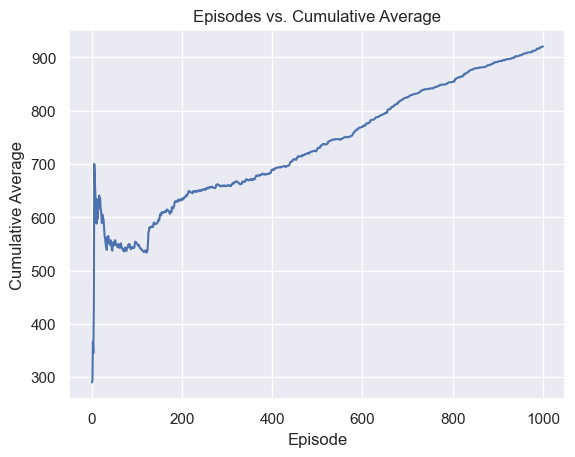

In [137]:
plot_cumulative_rewards(cum_avg_rewards_deep)

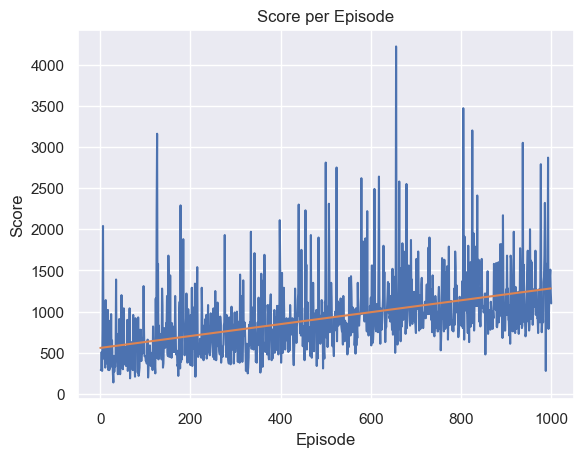

In [138]:
plot_scores(episode_scores_deep)


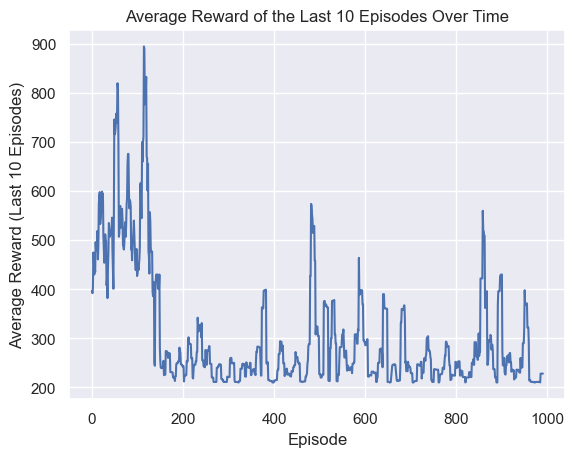

In [178]:
plot_last_10_avg(rolling_avg_last_10)